In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
def density_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=1e-3, r_max=1.5):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    Optionally compute and return mean halo concentration and virial mass.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite containing all halo data.
    
    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int
        Number of logarithmic radial bins used for density profile computation.

    r_min : float
        Minimum radius (in units of R_vir) for the radial binning range.

    r_max : float
        Maximum radius (in units of R_vir) for the radial binning range.

    """
    # Read basic simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # Particle mass [Msun]
    eps = params['eps'] / h  # Softening length [kpc]
    H0 = params["H0"]  # Hubble constant [km/s/Mpc]
    Om0 = params["Om0"]  # Matter density parameter

    # Compute background matter density rho_m = Omega_m * rho_crit
    H0_si = params["H0"] * u.km / u.s / u.Mpc
    G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
    rho_m = Om0 * rho_crit
    print(f'Om0={Om0}')

    cvir = []
    mvir = []

    for halo_idx in range(n_halos):
        # Get path to the current halo
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)
        
        try:
            # Read Rockstar halo catalog
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]   # Halo center position
        r_vir = host['rvir']     # Virial radius [kpc]


        cvir_val = host['cvir']
        cvir.append(cvir_val)
        mvir_val = host['m']
        mvir.append(mvir_val)

        # Read particle snapshot
        try:
            part = symlib.Particles(sim_dir)
            p = part.read(snap)
        except:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Compute radial distances from halo center
        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Create logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Compute mass in each spherical shell
        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Density [Msun/kpc^3]
        rho_scaled = rho / rho_m            # Scaled by background density

        # Save density profile to CSV
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{output_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} density profile saved.")

    # Return mean concentration and mass across halos
    mean_cvir = np.mean(cvir)
    mean_mvir = np.mean(mvir)
    print(f'mean cvir of {suite_name} is: {mean_cvir}, mean mvir is: {mean_mvir}')


In [ ]:
def velocity_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Measure the radial, tangential, and total velocity dispersion profiles, as well as the velocity anisotropy profile,
    for each host halo in a simulation suite at a given snapshot. Results are saved per halo.
    """
    
    # Read halo count and cosmological/simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    print(n_halos)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load host halo data
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        # Compute virial velocity
        center = host['x'][-1]         # Halo center [kpc]
        v_host = host['v'][-1]         # Halo bulk velocity [km/s]
        r_vir = host['rvir']           # Virial radius [kpc]
        m_vir = host['m']              # Virial mass [Msun]
        m = m_vir * u.Msun
        r = r_vir * u.kpc
        G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
        v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # Virial velocity [km/s]

        # Load particle data
        try:
            part = symlib.Particles(sim_dir)
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Positions and velocities in host frame
        x = p[0]['x']  # positions [kpc]
        v = p[0]['v']  # velocities [km/s]
        dx = x - center
        dv = v - v_host
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Decompose velocities: radial vs tangential
        r_hat = dx / radi[:, None]
        v_rad = np.sum(dv * r_hat, axis=1)
        v_tan = dv - v_rad[:, None] * r_hat

        # Set up logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Containers for profiles
        sigma_rad_scaled = []
        sigma_tan_scaled = []
        sigma_total_scaled = []
        beta_profile = []

        # Compute statistics in each bin
        for i in range(n_bins):
            in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i + 1])

            # Radial velocity dispersion
            sigma_rad = np.std(v_rad[in_bin])
            sigma_rad_scaled.append(sigma_rad / v_vir)

            # Total velocity dispersion (quadrature of components)
            sigma_x = np.std(dv[in_bin][:, 0])
            sigma_y = np.std(dv[in_bin][:, 1])
            sigma_z = np.std(dv[in_bin][:, 2])
            sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
            sigma_total_scaled.append(sigma_total / v_vir)

            if sigma_total < sigma_rad:  
                sigma_total = sigma_rad

            # Tangential dispersion (from subtraction)
            sigma_tan = np.sqrt(max(0, sigma_total**2 - sigma_rad**2))
            sigma_tan_scaled.append(sigma_tan / v_vir)

            # Velocity anisotropy beta = 1 - (sigma_tan^2) / (2 * sigma_rad^2)
            if sigma_rad == 0:
                beta = np.nan
            else:
                beta = 1 - sigma_tan**2 / (2 * sigma_rad**2)
            beta_profile.append(beta)

        # Save velocity profile for this halo
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "sigma_rad_scaled": sigma_rad_scaled,
            "sigma_tan_scaled": sigma_tan_scaled,
            "sigma_total_scaled": sigma_total_scaled,
            "beta": beta_profile
        })

        out_path = f"{output_dir}/output/{suite_name}/velocity_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} velocity profile saved.")

In [ ]:
def mass_profile(base_dir, suite_name, output_dir, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute and save the enclosed mass profile for each host halo,
    and plot all profiles together on a single figure.
    """

    # Simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h
    eps = params['eps'] / h

    # Prepare storage for all profiles
    all_r_scaled = []
    all_m_scaled = []

    for halo_idx in range(70, n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]
        m_vir = host['m']
        r_vir = host['rvir']

        try:
            part = symlib.Particles(sim_dir)
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        counts, _ = np.histogram(radi_scaled, bins=bins)
        mass_per_bin = counts * mp
        enclosed_mass = np.cumsum(mass_per_bin)
        m_scaled = enclosed_mass / m_vir

        # Save profile for later global plot
        all_r_scaled.append(bin_centers)
        all_m_scaled.append(m_scaled)

        # Save to CSV
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "m_scaled": m_scaled
        })
        out_path = f"{output_dir}/output/{suite_name}/mass_profiles"
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] {suite_name} Halo {halo_idx:03d} mass profile saved.")


In [ ]:
def particle_counts_distribution(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5):
    """
    Compute the average radial distribution of particle counts across all host halos
    in a simulation suite, normalized by the host halo's virial radius.
    """

    # Get total number of host halos
    n_halos = symlib.n_hosts(suite_name)
    all_counts = []

    # Define radial bin edges and centers (uniform across all halos)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load halo center and R_vir from Rockstar catalog
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue

        center = host['x'][-1]       # Halo center [kpc]
        r_vir = host['rvir']         # Virial radius [kpc]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)        # Distance from halo center [kpc]
        radi_scaled = radi / r_vir               # Normalize radius by R_vir

        # Bin particles by scaled radius
        counts, _ = np.histogram(radi_scaled, bins=bins)
        all_counts.append(counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for particle count statistics.")

    all_counts = np.array(all_counts)            # (n_halos, n_bins)
    mean_counts = np.mean(all_counts, axis=0)    # Mean across halos
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])  # Standard error

    plt.figure(figsize=(7, 5),dpi=500)
    plt.plot(bin_centers, mean_counts, label='Mean Particle Counts', color='pink')
    plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                    color='blue', alpha=0.3, label='Standard Error')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel("Average Particle Counts per Bin")
    plt.title(f"Average Particle Counts Profile across {len(all_counts)} Halos")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return bin_centers, mean_counts, stderr_counts

particle_counts_distribution(base_dir="/Volumes/Atlas/Symphony",suite_name="SymphonyMilkyWay", snap=235, n_bins=40, r_min=0.001, r_max=1.5)

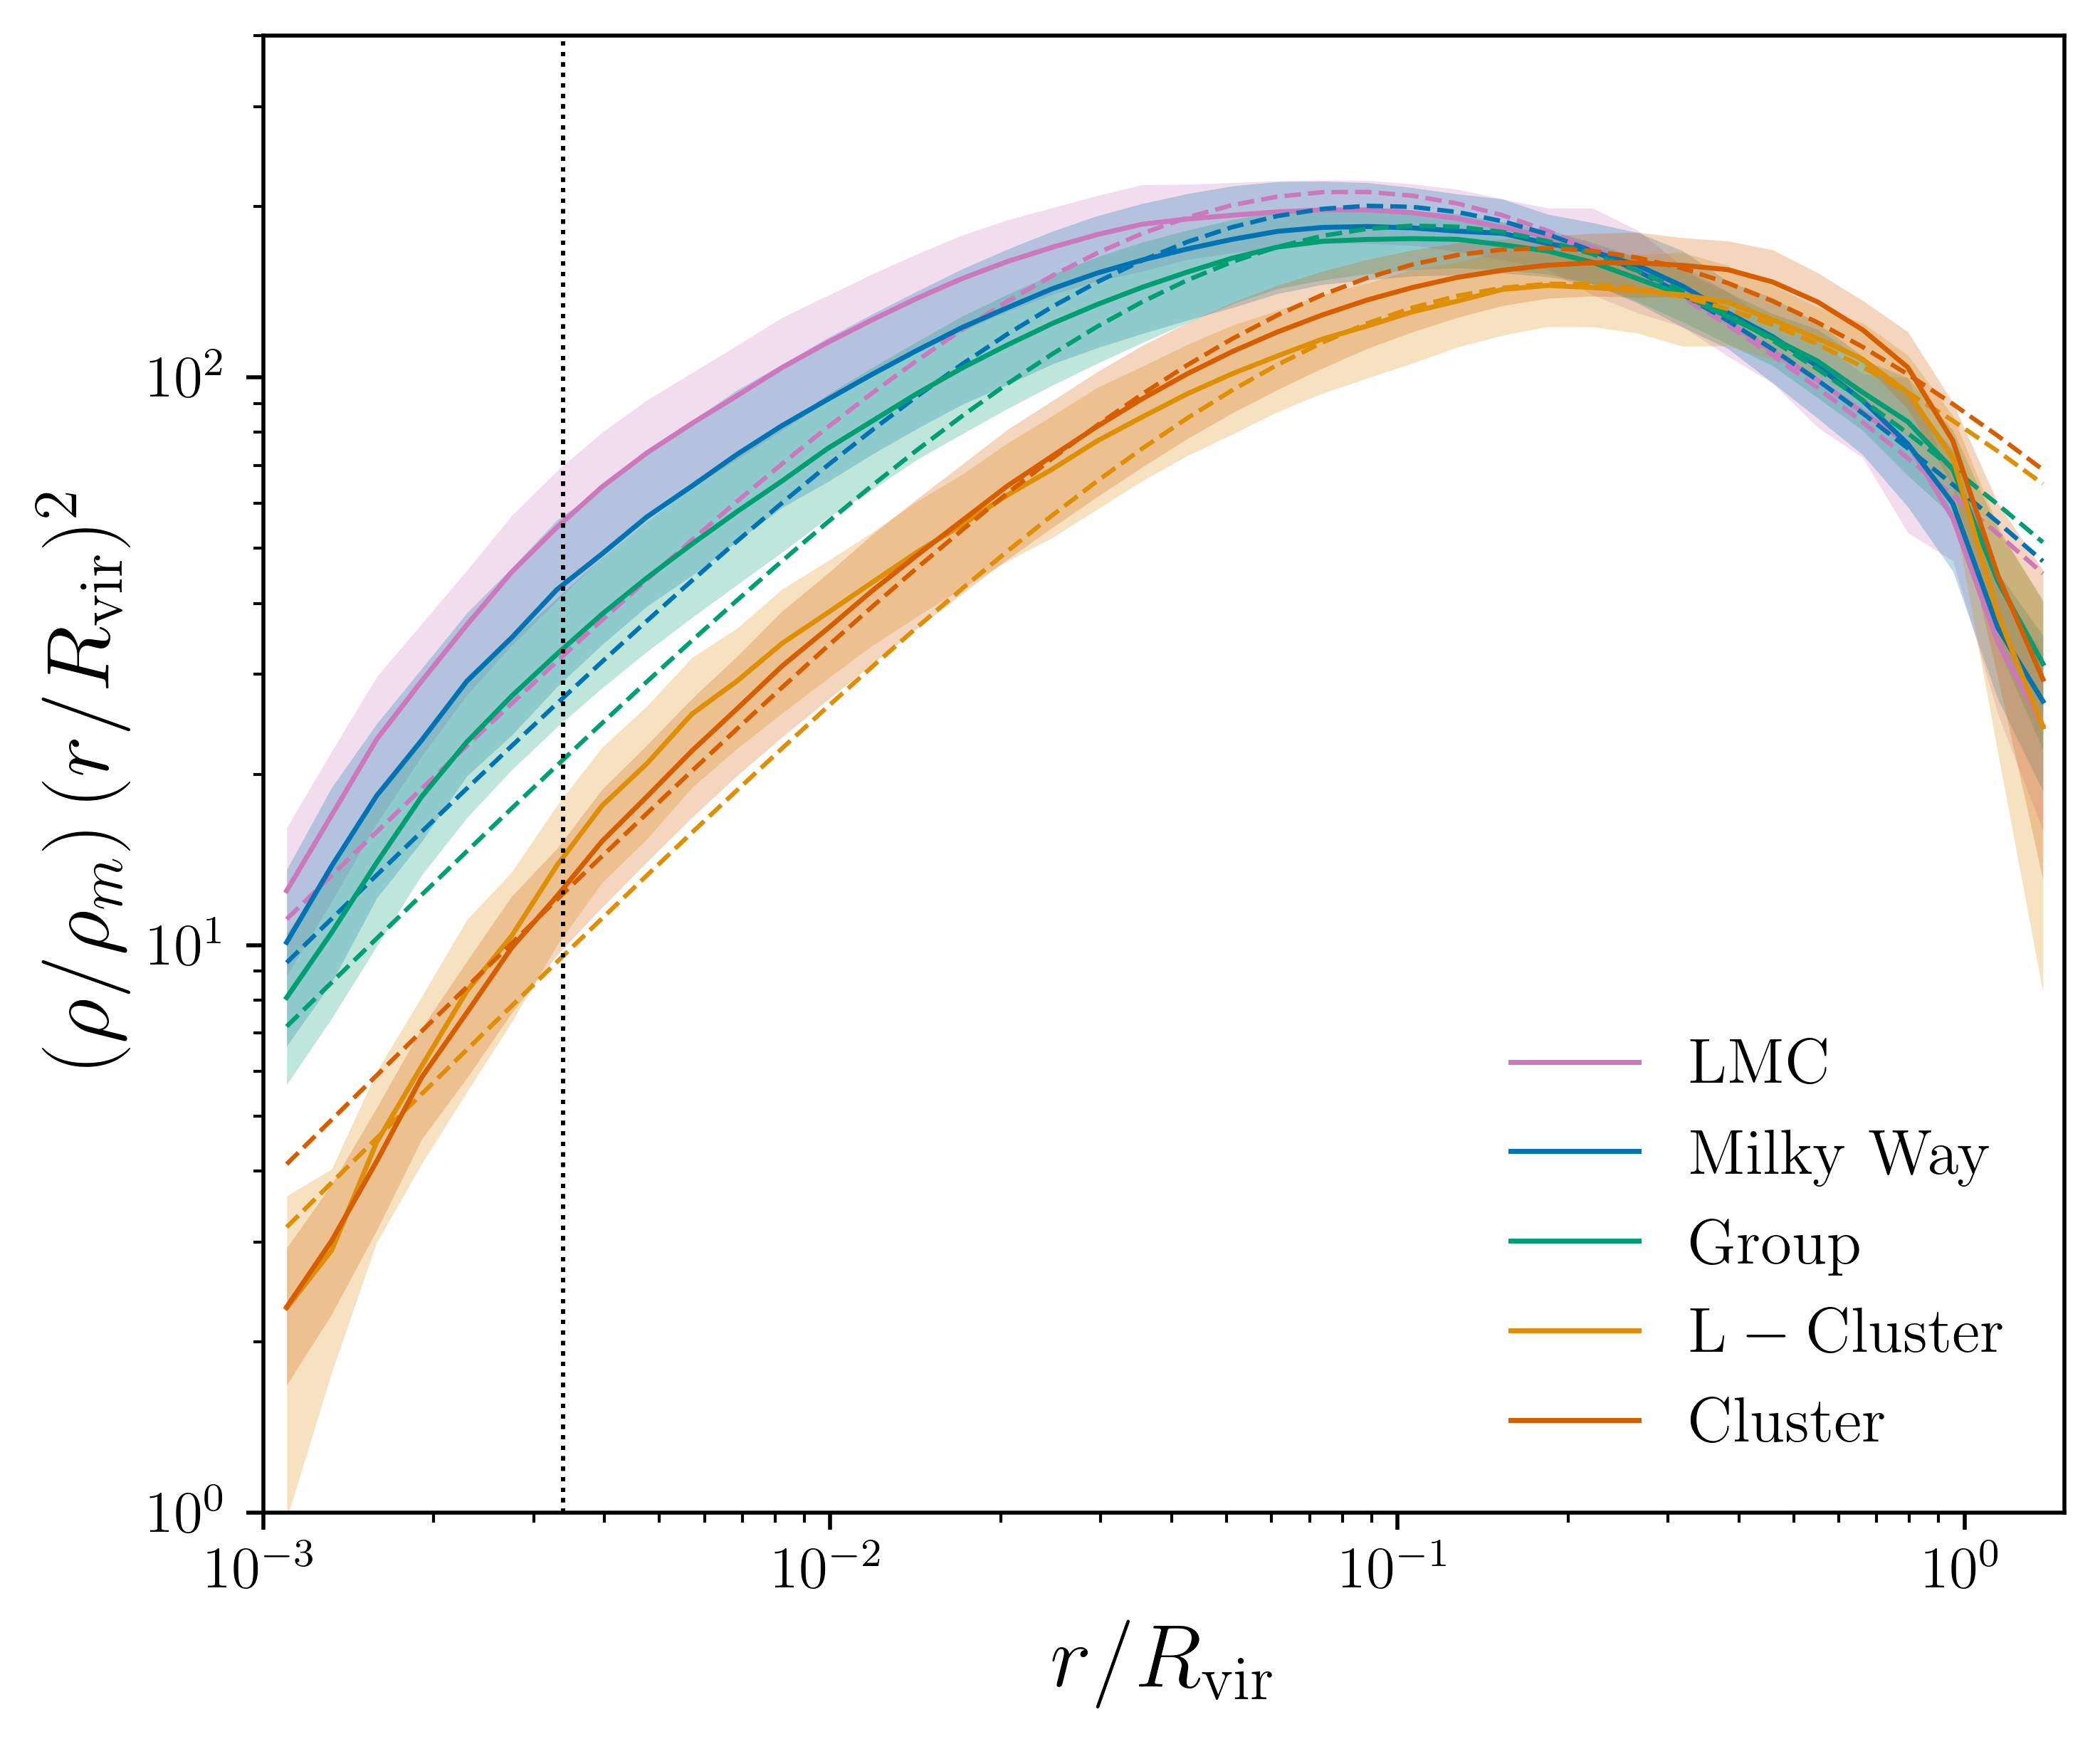

In [3]:
def rho_nfw(c, r, Delta_vir=99, Om0=0.286):
    f = np.log(1 + c) - c / (1 + c)
    x = r * c
    return Delta_vir * c**3 / (3 * f) / (x * (1 + x) ** 2) / Om0

Delta_vir_dic = {
    "SymphonyLMC": 99,
    "SymphonyMilkyWay": 99,
    "SymphonyGroup": 99,
    "SymphonyLCluster": 101,
    "SymphonyCluster": 94,
}
Om0_dic={
    "SymphonyLMC": 0.286,
    "SymphonyMilkyWay": 0.286,
    "SymphonyGroup": 0.286,
    "SymphonyLCluster": 0.3,
    "SymphonyCluster": 0.25,
}

def plot_density_profiles_mean(mask_range):
    plt.figure(figsize=(6, 5), dpi=500)
    plt.rcParams['text.usetex'] = True
    for suite in suite_names:
        params = symlib.simulation_parameters(suite)
        h = params['h100']
        eps = params['eps'] / h  # Softening length [kpc]
        r_vir = [pd.read_csv(os.path.join(base_dir, "output", suite, "virial_radius.csv"))]
        mean_rvir = np.mean(r_vir)
        conv_r = 2.8*eps/mean_rvir

        prof_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        files = sorted(glob(os.path.join(prof_dir, "halo_*_profile.csv")))
        p = [pd.read_csv(f) for f in files]
        r = p[0]["r_scaled"].to_numpy()
        if mask_range is not None:
            mask = (r >= mask_range[0]) & (r <= mask_range[1])
            r = r[mask]
        rho_r2 = np.array(
            [(d["rho_scaled"].to_numpy()[mask] if mask_range else d["rho_scaled"].to_numpy()) * r**2 for d in p]
        )
        mean = rho_r2.mean(axis=0)
        std = rho_r2.std(axis=0)
        color = sim_colors[suite]
        plt.loglog(r, mean, lw=1, color=color, label = rf"$\mathrm{{{sim_names[suite]}}}$")
        plt.fill_between(r, mean - std, mean + std, color=color, alpha=0.25, lw=0)
        plt.loglog(r, rho_nfw(mean_cvir[suite], r, Delta_vir=Delta_vir_dic[suite], Om0=Om0_dic[suite]) * r**2, ls="--", lw=0.9, color=color)
        plt.axvline(3.38e-3, ls=":" ,lw=0.8, color='black')

    plt.xlabel(r"$r / R_{\mathrm{vir}}$", fontsize=18)
    plt.ylabel(r"$(\rho / \rho_m)\,(r/R_{\mathrm{vir}})^2$", fontsize=18)
    plt.tick_params(axis='both', labelsize=12)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-3, 1.5)
    plt.ylim(1, 4e2)
    plt.legend(loc="best", fontsize=13, frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "density_profiles.pdf"))
    plt.show()
    plt.close()

plot_density_profiles_mean(mask_range=(1e-3, 1.5))


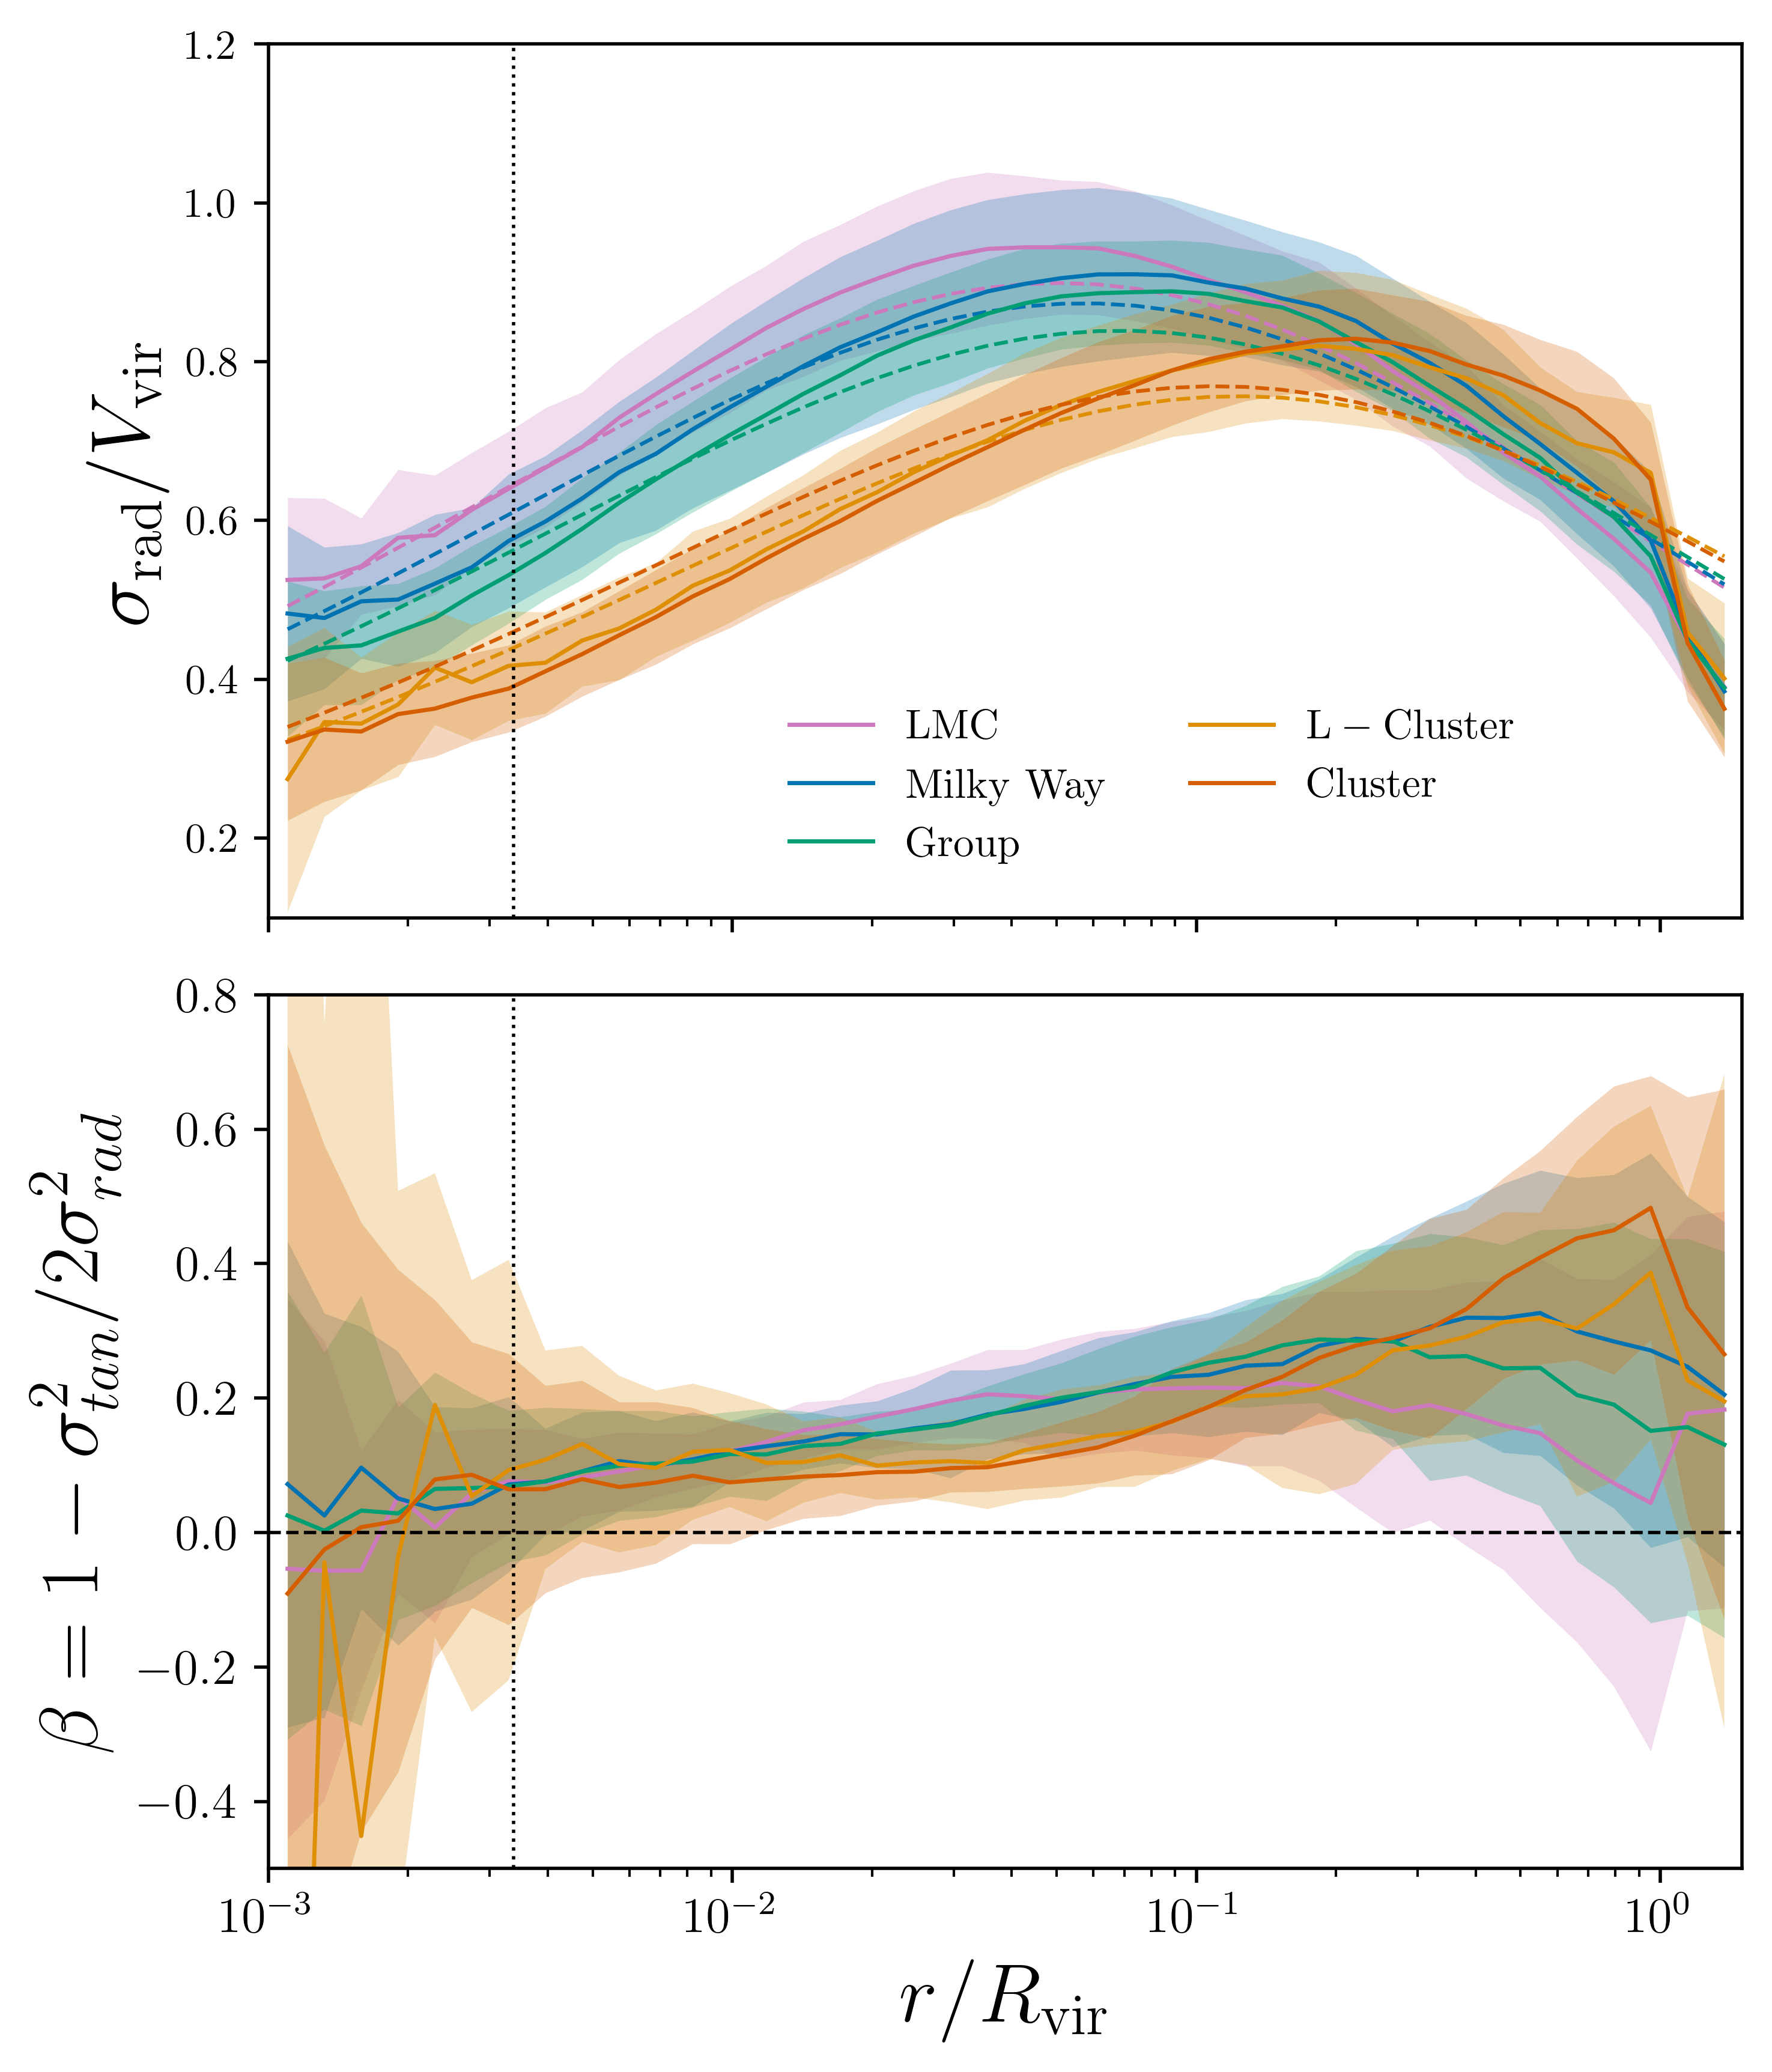

In [8]:
def nfw_sigma_r(x, cvir, beta):
    g_c = 1 / (np.log(1 + cvir) - cvir / (1 + cvir))

    def integrand(t):
        g_t = (t**(2*beta-3)*np.log(1+cvir*t)/(1 + cvir*t)**2) - (cvir*t**(2*beta-2)/(1 + cvir*t)**3)
        return g_t

    integral, _ = quad(integrand, x, np.inf)
    sigma_r2_scaled = g_c *  (1 + cvir * x)**2 * x**(1 - 2*beta) * integral

    return np.sqrt(sigma_r2_scaled)

def plot_sigma_r_and_beta():
    fig, (ax_sig, ax_beta) = plt.subplots(2, 1, figsize=(6, 7), dpi=500, sharex=True)
    plt.rcParams['text.usetex'] = True

    for suite in suite_names:
        vdir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        files = sorted(glob(os.path.join(vdir, "halo_*_profile.csv")))

        profs = [pd.read_csv(f) for f in files]
        r = profs[0]["r_scaled"].to_numpy()
        sig_r = np.vstack([p["sigma_rad_scaled"].to_numpy() for p in profs])
        beta  = np.vstack([p["beta"].to_numpy()              for p in profs])
        
        sig_mean, sig_std = sig_r.mean(axis=0), sig_r.std(axis=0)
        beta_mean, beta_std = beta.mean(axis=0), beta.std(axis=0)

        ax_sig.plot(r, sig_mean, lw=1, color=sim_colors[suite], label=rf"$\mathrm{{{sim_names[suite]}}}$")
        ax_sig.fill_between(r, sig_mean - sig_std, sig_mean + sig_std,
                            color=sim_colors[suite], alpha=0.25, lw=0)

        nfw = np.array([nfw_sigma_r(x=x, cvir=mean_cvir[suite], beta=0.15) for x in r])
        ax_sig.plot(r, nfw, ls="--", lw=0.9, color=sim_colors[suite])

        ax_beta.semilogx(r, beta_mean, lw=1, color=sim_colors[suite], label=rf"$\mathrm{{{sim_names[suite]}}}$")
        ax_beta.fill_between(r, beta_mean - beta_std, beta_mean + beta_std,
                             color=sim_colors[suite], alpha=0.25, lw=0)
        
    ax_sig.set_ylabel(r"$\sigma_{\rm rad}/V_{\rm vir}$", fontsize=20)
    ax_sig.set_xlim(1e-3,1.5)
    ax_sig.set_ylim(0.1, 1.2)
    ax_sig.axvline(3.38e-3, ls=":" ,lw=0.8, color='black')
    ax_sig.legend(fontsize=10, ncol=2, frameon=False, loc='center', bbox_to_anchor=(0.6, 0.15))

    ax_beta.set_xlabel(r"$r/R_{\mathrm{vir}}$", fontsize=20)
    ax_beta.set_ylabel(r"$\beta = 1 - \sigma_{tan}^2 / 2 \sigma_{rad}^2$", fontsize=20)
    ax_beta.set_ylim(-0.5, 0.8)
    ax_beta.axhline(0, color="k", ls="--", lw=0.8)
    ax_beta.axvline(3.38e-3, ls=":" ,lw=0.8, color='black')


    plt.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "velocity_profiles.pdf"))
    plt.show()
    plt.close()

plot_sigma_r_and_beta()